<a href="https://colab.research.google.com/github/leonardoub/cmepda/blob/master/BRATS_Kfold_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [19]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
dataset_path = '/gdrive/My Drive/BRATS/data_without_NAN_without_HISTO_with_histologies.csv'

In [0]:
df_data = pd.read_csv(dataset_path)

In [22]:
df_data

,ID,Date,VOLUME_ET,VOLUME_NET,VOLUME_ED,VOLUME_TC,VOLUME_WT,VOLUME_BRAIN,VOLUME_ET_OVER_NET,VOLUME_ET_OVER_ED,VOLUME_NET_OVER_ED,VOLUME_ET_over_TC,VOLUME_NET_over_TC,VOLUME_ED_over_TC,VOLUME_ET_OVER_WT,VOLUME_NET_OVER_WT,VOLUME_ED_OVER_WT,VOLUME_TC_OVER_WT,VOLUME_ET_OVER_BRAIN,VOLUME_NET_OVER_BRAIN,VOLUME_ED_over_BRAIN,VOLUME_TC_over_BRAIN,VOLUME_WT_OVER_BRAIN,DIST_Vent_TC,DIST_Vent_ED,INTENSITY_Mean_ET_T1Gd,INTENSITY_STD_ET_T1Gd,INTENSITY_Mean_ET_T1,INTENSITY_STD_ET_T1,INTENSITY_Mean_ET_T2,INTENSITY_STD_ET_T2,INTENSITY_Mean_ET_FLAIR,INTENSITY_STD_ET_FLAIR,INTENSITY_Mean_NET_T1Gd,INTENSITY_STD_NET_T1Gd,INTENSITY_Mean_NET_T1,INTENSITY_STD_NET_T1,INTENSITY_Mean_NET_T2,INTENSITY_STD_NET_T2,INTENSITY_Mean_NET_FLAIR,...,TEXTURE_NGTDM_ED_T1_Busyness,TEXTURE_NGTDM_ED_T1_Complexity,TEXTURE_NGTDM_ED_T1_Strength,TEXTURE_NGTDM_ED_T2_Coarseness,TEXTURE_NGTDM_ED_T2_Contrast,TEXTURE_NGTDM_ED_T2_Busyness,TEXTURE_NGTDM_ED_T2_Complexity,TEXTURE_NGTDM_ED_T2_Strength,TEXTURE_NGTDM_ED_FLAIR_Coarseness,TEXTURE_NGTDM_ED_FLAIR_Contrast,TEXTURE_NGTDM_ED_FLAIR_Busyness,TEXTURE_NGTDM_ED_FLAIR_Complexity,TEXTURE_NGTDM_ED_FLAIR_Strength,TEXTURE_NGTDM_NET_T1Gd_Coarseness,TEXTURE_NGTDM_NET_T1Gd_Contrast,TEXTURE_NGTDM_NET_T1Gd_Busyness,TEXTURE_NGTDM_NET_T1Gd_Complexity,TEXTURE_NGTDM_NET_T1Gd_Strength,TEXTURE_NGTDM_NET_T1_Coarseness,TEXTURE_NGTDM_NET_T1_Contrast,TEXTURE_NGTDM_NET_T1_Busyness,TEXTURE_NGTDM_NET_T1_Complexity,TEXTURE_NGTDM_NET_T1_Strength,TEXTURE_NGTDM_NET_T2_Coarseness,TEXTURE_NGTDM_NET_T2_Contrast,TEXTURE_NGTDM_NET_T2_Busyness,TEXTURE_NGTDM_NET_T2_Complexity,TEXTURE_NGTDM_NET_T2_Strength,TEXTURE_NGTDM_NET_FLAIR_Coarseness,TEXTURE_NGTDM_NET_FLAIR_Contrast,TEXTURE_NGTDM_NET_FLAIR_Busyness,TEXTURE_NGTDM_NET_FLAIR_Complexity,TEXTURE_NGTDM_NET_FLAIR_Strength,TGM_p1,TGM_dw,TGM_Cog_X_1,TGM_Cog_Y_1,TGM_Cog_Z_1,TGM_T_1,Histology
0,TCGA-02-0006,1996.08.23,1662,384,36268,2046,38314,1469432,4.328125,0.045826,0.010588,0.812320,0.187680,17.726300,0.043378,0.010022,0.946599,0.053401,0.001131,0.000261,0.024682,0.001392,0.026074,31.5903,2.7735,149.7977,10.4671,194.1422,15.1037,154.9225,43.4709,220.5894,30.2917,137.8881,6.3820,183.6933,14.8846,161.1005,35.8591,227.7510,...,0.86315,1479.9762,1.10870,0.000605,0.40937,1.47070,2992.2698,0.71642,0.000690,0.28977,1.8815,1872.0528,0.75986,0.026040,0.37869,0.060929,1675.0041,14.11380,0.044156,0.41942,0.026740,2536.7559,43.31290,0.036634,0.50304,0.024264,3593.3279,43.67590,0.057204,0.33980,0.021897,2203.2034,61.32930,8.00000,7.500000e-07,0.178609,0.096256,0.052741,2.00000,GBM
1,TCGA-02-0009,1997.06.14,4362,4349,15723,8711,24434,1295721,1.002989,0.277428,0.276601,0.500750,0.499250,1.805000,0.178522,0.177990,0.643489,0.356511,0.003366,0.003356,0.012135,0.006723,0.018857,9.2443,3.0207,165.4345,6.4047,201.2400,13.4733,113.1601,10.1373,210.1810,15.9543,152.6013,4.2360,188.0607,11.1316,116.8538,10.0992,209.7901,...,0.40004,2378.9184,2.54730,0.000914,0.70926,0.78063,5719.2847,1.29980,0.000882,0.48919,1.8243,2954.8148,0.77199,0.002254,0.29324,1.223600,539.3057,0.53125,0.005712,0.20995,0.315580,967.7845,3.74440,0.003790,0.36163,0.271420,1996.1440,2.77050,0.004966,0.28715,0.189980,1440.4285,3.59990,3.31250,1.000000e-09,0.077618,0.122900,0.094336,91.47360,GBM
2,TCGA-02-0011,1998.02.01,33404,48612,45798,82016,127814,1425843,0.687155,0.729377,1.061444,0.407290,0.592710,0.558400,0.261349,0.380334,0.358318,0.641682,0.023428,0.034094,0.032120,0.057521,0.089641,1.0000,1.0000,186.3385,17.6126,188.2019,23.5195,172.8969,32.7401,167.1395,34.1684,149.0643,12.9090,158.4197,15.2632,197.4966,27.1781,165.1014,...,1.51780,1750.3404,0.56482,0.000382,0.59301,1.81810,4990.3388,0.54747,0.000345,0.59184,2.4243,4703.9458,0.41937,0.000403,0.37863,1.957500,2509.3979,0.42842,0.000768,0.19849,1.395800,1322.6082,0.74730,0.000634,0.31856,1.144300,2517.8629,0.84294,0.000794,0.17961,1.068800,1147.5177,0.80480,5.78125,1.000000e-09,0.132283,0.116006,0.096035,272.42900,GBM
3,TCGA-02-0027,1999.03.28,12114,7587,34086,19701,53787,1403429,1.596679,0.355395,0.222584,

In [23]:
df_data.columns

Index(['ID', 'Date', 'VOLUME_ET', 'VOLUME_NET', 'VOLUME_ED', 'VOLUME_TC',
       'VOLUME_WT', 'VOLUME_BRAIN', 'VOLUME_ET_OVER_NET', 'VOLUME_ET_OVER_ED',
       ...
       'TEXTURE_NGTDM_NET_FLAIR_Busyness',
       'TEXTURE_NGTDM_NET_FLAIR_Complexity',
       'TEXTURE_NGTDM_NET_FLAIR_Strength', 'TGM_p1', 'TGM_dw', 'TGM_Cog_X_1',
       'TGM_Cog_Y_1', 'TGM_Cog_Z_1', 'TGM_T_1', 'Histology'],
      dtype='object', length=587)

In [0]:
data = df_data.drop(['Histology', 'ID', 'Date'], axis=1)

In [0]:
labels = df_data.Histology

##Encode labels

In [0]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
labels_enc = encoder.fit_transform(labels)

##Building Network

In [35]:
import keras
from keras import layers
from keras.preprocessing import sequence

Using TensorFlow backend.


In [0]:
from keras.optimizers import RMSprop
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import Adam
from keras.optimizers import Adamax
from keras.optimizers import Nadam
from keras.optimizers import SGD

In [0]:
from keras import regularizers

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(20, activation='relu', input_shape=(584,), kernel_regularizer=regularizers.l2(l=0.05)))
  #model.add(layers.Dropout(0.01))
  #model.add(layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(l=0.05)))
  #model.add(layers.Dropout(0.01))

  model.add(layers.Dense(1, activation='sigmoid'))

  sgd = SGD(lr=0.05, momentum=0.9)
  adam = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
  rmsprop = RMSprop(lr=0.001)

  model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [0]:
from keras.callbacks import ReduceLROnPlateau
red_lr = ReduceLROnPlateau('val_loss', patience=10, verbose=1, factor=0.1, min_lr=0.0001)
#usandolo la loss non scende anche se non agisce, COME MAI????
#non usandolo e non variando nient'altro la loss scende molto rapidamente

In [0]:
num_epochs = 500

model = build_model()
history = model.fit(train_data_stand, train_labels_enc, validation_data=(val_data_stand, val_labels_enc), 
                      epochs= num_epochs, batch_size=92, callbacks=[red_lr])
  

acc_history = history.history['accuracy']
loss_history = history.history['loss']
acc_val_history = history.history['val_accuracy']
loss_val_history = history.history['val_loss']


#Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [0]:
for train_index, test_index in skf.split(data, labels_enc):
    print("TRAIN:", train_index, "TEST:", test_index)

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [71]:
num_epochs = 100
all_acc_histories = []
all_loss_histories = []
all_val_acc_histories = []
all_val_loss_histories = []
cvscores = []

for train_index, val_index in skf.split(data, labels_enc):
 
  partial_train_data = data.iloc[train_index, :]
  partial_train_targets = labels_enc[train_index]
  
  val_data = data.iloc[val_index, :]
  val_targets = labels_enc[val_index]

  scaler = MinMaxScaler()
  partial_train_data_scaled = scaler.fit_transform(partial_train_data)
  val_data_scaled = scaler.transform(val_data)
 
  model = build_model()
  history = model.fit(partial_train_data_scaled, partial_train_targets, validation_data=(val_data_scaled, val_targets), 
                      epochs=num_epochs, batch_size=92, callbacks=[red_lr])
  
  acc_history = history.history['accuracy']
  all_acc_histories.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  acc_val_history = history.history['val_accuracy']
  all_val_acc_histories.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories.append(loss_val_history)
  
  scores = model.evaluate(val_data_scaled, val_targets)
  cvscores.append(scores)
#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 116 samples, validate on 30 samples
Epoch 1/100
116/116 [==============================] - 0s 892us/step - loss: 2.6877 - accuracy: 0.4138 - val_loss: 2.2369 - val_accuracy: 0.7000
Epoch 2/100
116/116 [==============================] - 0s 71us/step - loss: 2.1355 - accuracy: 0.6983 - val_loss: 1.6126 - val_accuracy: 0.8333
Epoch 3/100
116/116 [==============================] - 0s 66us/step - loss: 1.6045 - accuracy: 0.8276 - val_loss: 1.2394 - val_accuracy: 0.8000
Epoch 4/100
116/116 [==============================] - 0s 73us/step - loss: 1.2533 - accuracy: 0.7759 - val_loss: 1.0159 - val_accuracy: 0.7667
Epoch 5/100
116/116 [==============================] - 0s 73us/step - loss: 1.0374 - accuracy: 0.7586 - val_loss: 0.8961 - val_accuracy: 0.9333
Epoch 6/100
116/116 [==============================] - 0s 78us/step - loss: 0.9409 - accuracy: 0.8793 - val_loss: 0.7927 - val_accuracy: 0.9000
Epoch 7/100
116/116 [==============================] - 0s 79us/step - loss: 0.8386 - accur

In [0]:
history_dict = history.history 

In [0]:
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])

In [72]:
cvscores

[[0.34324508905410767, 0.9333333373069763],
 [0.5186513066291809, 0.7931034564971924],
 [0.277778685092926, 0.9655172228813171],
 [0.5730763673782349, 0.8620689511299133],
 [0.3666653633117676, 0.8965517282485962]]

In [0]:
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]


In [68]:
len(average_val_acc_history)

100

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

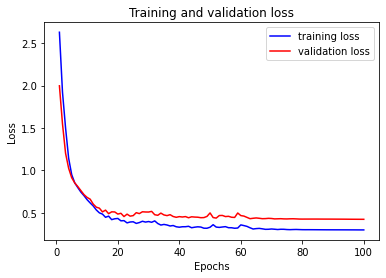

In [69]:
plt.plot(epochs, average_loss_history, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history, 'r', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

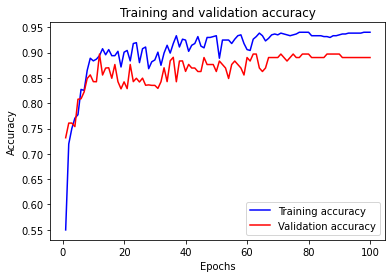

In [70]:
plt.plot(epochs, average_acc_history, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 